In [2]:
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
import xgboost as xgb

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.model_selection import cross_val_score, cross_validate

In [11]:
from sklearn.linear_model import RidgeCV

In [12]:
from sklearn.linear_model import LassoCV

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [15]:
from sklearn.metrics import make_scorer

In [16]:
from sklearn.metrics import classification_report

In [17]:
from sklearn.model_selection import StratifiedKFold

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [20]:
from imblearn.over_sampling import SMOTE


In [21]:
import seaborn as sns

In [22]:
from sklearn.naive_bayes import GaussianNB

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
from sklearn.neural_network import MLPClassifier

In [25]:
from sklearn.metrics import classification_report

In [26]:
from scipy import stats

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [107]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

### Run baseline model

In [29]:
df = pd.read_csv('Data/diabetes.csv')

In [30]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

##### Exploratory data analysis

#### Plotting all the features with histogram, seaborn and boxplot

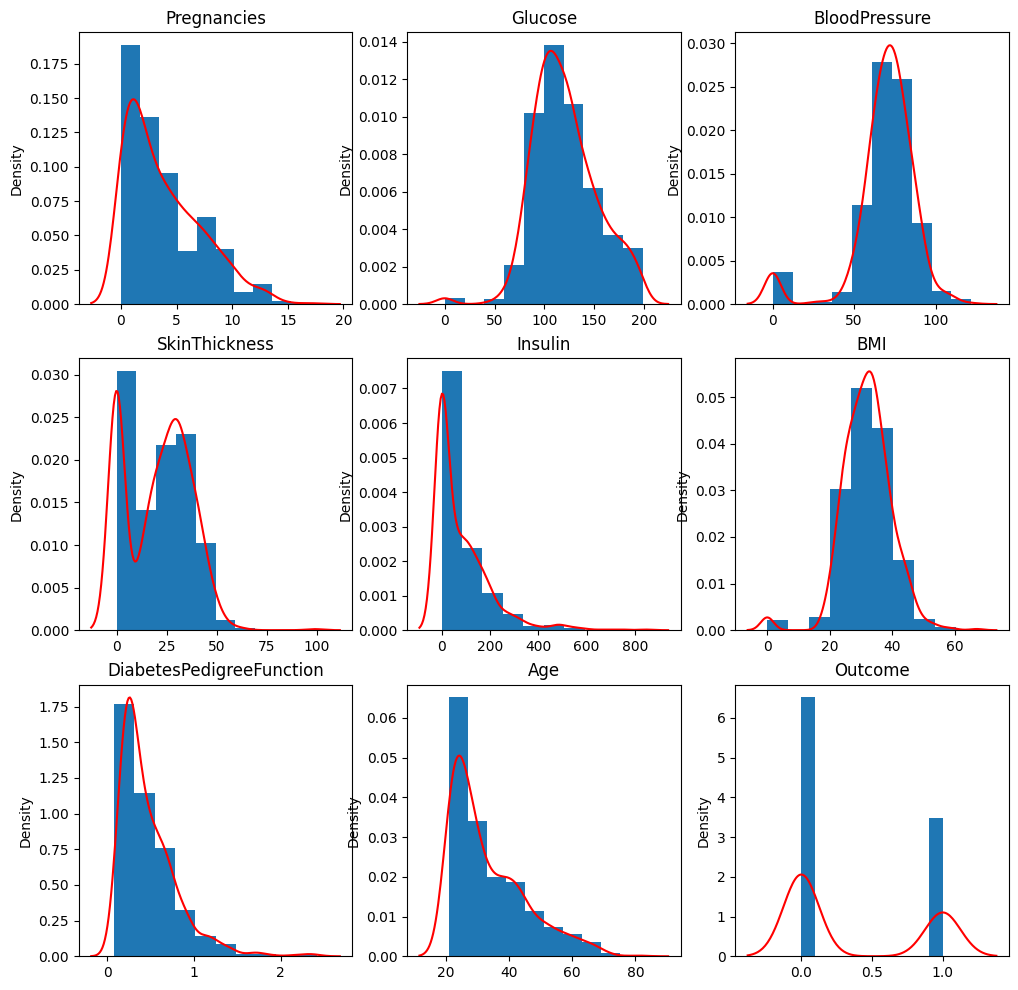

In [31]:
#hist plot
fig, axs = plt.subplots(3,3, figsize=(12,12))
for i, ax in  enumerate(axs.flat):
    ax.hist(df[df.columns[i]], density=True)
    sns.kdeplot(df[df.columns[i]], ax=ax, label='KDE', color='red')
    ax.set_xlabel(None)
    ax.set_title(str(df.columns[i]))

<Axes: >

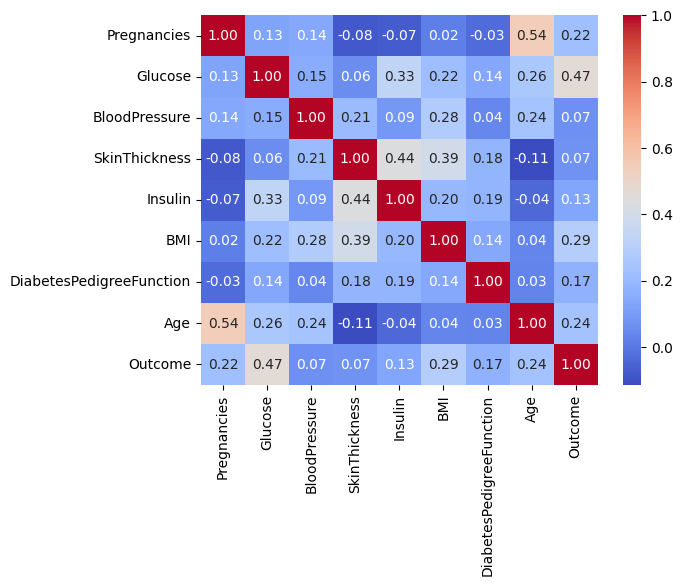

In [32]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")

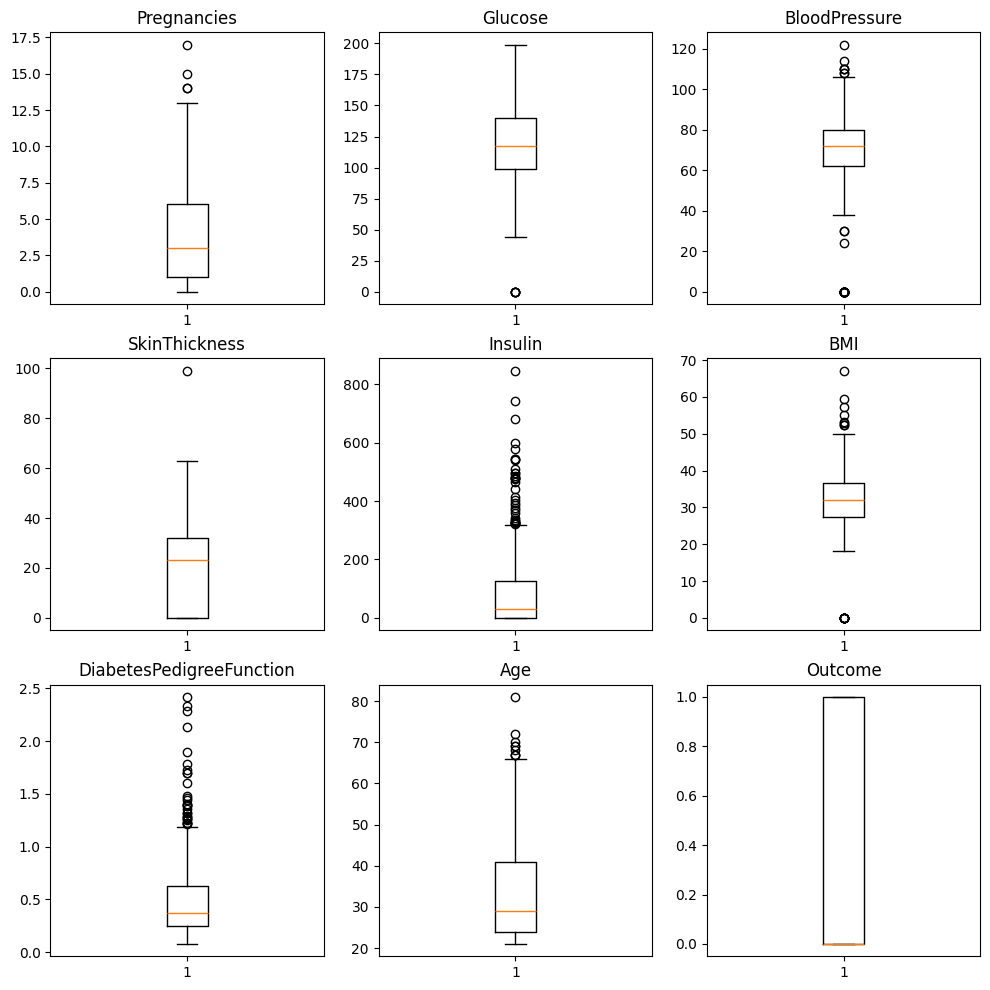

In [33]:
#box plot
fig, axs = plt.subplots(3,3, figsize=(12,12))
for i, ax in enumerate(axs.flat):
    ax.boxplot(df[df.columns[i]])
    ax.set_title(df.columns[i])

##### Checking columns with zero appart form pregnancy since it we can have zero pregnancy and replacing it with the mean value

In [34]:
cols_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [35]:
df[cols_to_check]

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148,72,35,0,33.6,0.627,50
1,85,66,29,0,26.6,0.351,31
2,183,64,0,0,23.3,0.672,32
3,89,66,23,94,28.1,0.167,21
4,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...
763,101,76,48,180,32.9,0.171,63
764,122,70,27,0,36.8,0.340,27
765,121,72,23,112,26.2,0.245,30
766,126,60,0,0,30.1,0.349,47


In [36]:
has_zero = (df[cols_to_check] == 0).any()

In [37]:
has_zero

Glucose                      True
BloodPressure                True
SkinThickness                True
Insulin                      True
BMI                          True
DiabetesPedigreeFunction    False
Age                         False
dtype: bool

In [38]:
has_zero.values.astype(int)

array([1, 1, 1, 1, 1, 0, 0])

In [39]:
cols_affected = [col for col, m in zip(cols_to_check, has_zero.values.astype(int)) if m==1]

In [40]:
list(zip(cols_to_check, has_zero.values.astype(int)))

[('Glucose', 1),
 ('BloodPressure', 1),
 ('SkinThickness', 1),
 ('Insulin', 1),
 ('BMI', 1),
 ('DiabetesPedigreeFunction', 0),
 ('Age', 0)]

In [41]:
cols_affected

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [42]:
df1 = df.copy()

In [43]:
for col in cols_affected:
    df[col].replace(0, np.nan, inplace=True)

In [44]:
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [45]:
for col in cols_affected:
    df[col].replace(np.nan, df[col].mean(), inplace=True)

In [46]:
df['Glucose'].mean()

121.68676277850591

##### Trying to remove outliers

In [47]:
z_scores = np.abs(stats.zscore(df.drop(['Outcome'], axis=1)))

In [48]:
z_scores

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,0.033518,6.655021e-01,3.345079e-16,0.166292,0.468492,1.425995
1,0.844885,1.206162,0.529859,1.746338e-02,3.345079e-16,0.852531,0.365061,0.190672
2,1.233880,2.015813,0.695306,8.087936e-16,3.345079e-16,1.332833,0.604397,0.105584
3,0.844885,1.074652,0.529859,7.004289e-01,7.243887e-01,0.634212,0.920763,1.041549
4,1.141852,0.503458,2.680669,6.655021e-01,1.465506e-01,1.548980,5.484909,0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,0.680125,0.297376,2.145261e+00,2.877840e-01,0.064409,0.908682,2.532136
764,0.547919,0.010298,0.198965,2.451185e-01,3.345079e-16,0.632039,0.398282,0.531023
765,0.342981,0.022579,0.033518,7.004289e-01,5.125386e-01,0.910750,0.685193,0.275760
766,0.844885,0.141808,1.026200,8.087936e-16,3.345079e-16,0.343120,0.371101,1.170732


In [49]:
outliers = (z_scores > 3).any(axis=1)

In [50]:
outliers

0      False
1      False
2      False
3      False
4       True
       ...  
763    False
764    False
765    False
766    False
767    False
Length: 768, dtype: bool

In [51]:
df[outliers]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137.0,40.000000,35.00000,168.000000,43.100000,2.288,33,1
8,2,197.0,70.000000,45.00000,543.000000,30.500000,0.158,53,1
13,1,189.0,60.000000,23.00000,846.000000,30.100000,0.398,59,1
18,1,103.0,30.000000,38.00000,83.000000,43.300000,0.183,33,0
43,9,171.0,110.000000,24.00000,240.000000,45.400000,0.721,54,1
45,0,180.0,66.000000,39.00000,155.548223,42.000000,1.893,25,1
57,0,100.0,88.000000,60.00000,110.000000,46.800000,0.962,31,0
58,0,146.0,82.000000,29.15342,155.548223,40.500000,1.781,44,0
88,15,136.0,70.000000,32.00000,110.000000,37.100000,0.153,43,1
106,1,96.0,122.000000,29.15342,155.548223,22.400000,0.207,27,0


In [52]:
df[outliers].shape

(49, 9)

In [53]:
df_clean = df[~outliers]

In [54]:
df_clean.shape

(719, 9)

In [55]:
X_clean_train, X_clean_test, Y_clean_train, Y_clean_test = train_test_split(df_clean.drop(['Outcome'], axis=1), df_clean['Outcome'], stratify = df_clean['Outcome'],  test_size=0.20, random_state=42)

In [56]:
X_clean_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
674,8,91.0,82.0,29.15342,155.548223,35.6,0.587,68
283,7,161.0,86.0,29.15342,155.548223,30.4,0.165,47
368,3,81.0,86.0,16.00000,66.000000,27.5,0.306,22
661,1,199.0,76.0,43.00000,155.548223,42.9,1.394,22
359,1,196.0,76.0,36.00000,249.000000,36.5,0.875,29


In [57]:
Y_clean_test

674    0
283    1
368    0
661    1
359    1
      ..
447    0
449    0
739    1
2      1
364    0
Name: Outcome, Length: 144, dtype: int64

In [58]:
Scaler = StandardScaler()

In [59]:
X_clean_train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [60]:
X_train1 = X_clean_train.copy()

In [61]:
Scaler.fit(X_clean_train)

StandardScaler()

In [62]:
X_clean_train[X_clean_train.columns] = Scaler.transform(X_clean_train)

In [63]:
X_clean_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
654,-0.876880,-0.484789,-0.176518,-0.074457,-0.169774,0.330459,-1.083767,-0.956853
611,-0.257843,1.880056,-1.222045,-0.814402,0.882907,0.130728,0.527183,0.282514
360,0.361195,2.401713,-0.699282,0.542164,3.220216,-0.130458,0.491463,-0.337169
452,-1.186399,-1.006446,-0.350773,0.418840,1.168380,1.206200,-0.230071,-0.691274
245,1.599270,2.227827,1.130390,-1.677672,0.196849,-0.314825,2.741793,1.433355
...,...,...,...,...,...,...,...,...
408,1.289751,2.679930,0.171991,0.067788,0.196849,-0.944744,2.663210,0.548093
49,0.980232,-0.519566,0.033039,0.067788,0.196849,0.062737,-0.501539,-0.779800
349,0.361195,0.060751,0.694754,0.418840,0.196849,1.375203,-0.355089,0.371040
280,-1.186399,0.906296,-0.176518,0.067788,0.196849,0.898923,-0.397953,-0.425696


In [64]:
X_clean_test[X_clean_test.columns] = Scaler.transform(X_clean_test)

In [65]:
X_clean_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
674,1.289751,-1.006446,0.869009,0.067788,0.196849,0.545553,0.505751,3.115353
283,0.980232,1.427953,1.217518,0.067788,0.196849,-0.253369,-1.001612,1.256302
368,-0.257843,-1.354218,1.217518,-1.554348,-1.400875,-0.698922,-0.497967,-0.956853
661,-0.876880,2.749484,0.346245,1.775407,0.196849,1.667117,3.388316,-0.956853
359,-0.876880,2.645153,0.346245,0.912137,1.864220,0.683828,1.534473,-0.337169
...,...,...,...,...,...,...,...,...
447,-1.186399,-0.867338,0.694754,2.022055,-0.936982,0.683828,-0.412240,-0.602748
449,-1.186399,0.002091,0.171991,-1.307699,-1.454401,-0.238005,-0.572978,-0.602748
739,-0.876880,-0.623898,0.171991,0.067788,0.196849,1.144745,-0.544403,0.813671
2,1.289751,2.193050,-0.699282,0.067788,0.196849,-1.344205,0.809367,-0.071591


###### Applying smoting

In [66]:
smote = SMOTE(random_state = 42)

In [67]:
X_res, Y_res = smote.fit_resample(X_clean_train, Y_clean_train)

In [68]:
print("Before SMOTE class counts:\n", Y_clean_train.value_counts())
print("After  SMOTE class counts:\n", Y_res.value_counts())

Before SMOTE class counts:
 Outcome
0    381
1    194
Name: count, dtype: int64
After  SMOTE class counts:
 Outcome
0    381
1    381
Name: count, dtype: int64


In [69]:
print("Mean value for Y_clean_test and Y_clean_train")
print(Y_clean_test.mean())
print(Y_clean_train.mean())

Mean value for Y_clean_test and Y_clean_train
0.3333333333333333
0.3373913043478261


##### Choosing best feature for feature engineering, we choose feature that will be used for feature engineering, for this we use decision tree method and ultimately engineering the features


In [70]:
from sklearn.tree import DecisionTreeClassifier

In [71]:
dt = DecisionTreeClassifier(max_depth=3, random_state=24)

In [72]:
dt.fit(df.drop(['Outcome'], axis=1), df['Outcome'])

DecisionTreeClassifier(max_depth=3, random_state=24)

In [73]:
importances = pd.Series(dt.feature_importances_, index=X_clean_train.columns)
top_feats = importances.nlargest(3).index.tolist()
top_feats

['Glucose', 'BMI', 'Age']

In [74]:
importances

Pregnancies                 0.000000
Glucose                     0.619553
BloodPressure               0.000000
SkinThickness               0.000000
Insulin                     0.000000
BMI                         0.260940
DiabetesPedigreeFunction    0.000000
Age                         0.119507
dtype: float64

In [75]:
X_res_p = X_res.copy()

In [76]:
X_test_p = X_clean_test.copy()

In [77]:
X_train_p = X_clean_train.copy()

In [78]:
for feat in top_feats:
    X_res_p[f'{feat}_sq'] = X_res_p[feat] **2
    X_train_p[f'{feat}_sq'] = X_train_p[feat] **2
    X_test_p[f'{feat}_sq'] = X_test_p[feat] **2

##### Adding new features

In [79]:
X_res_p['Glucose_x_BMI'] = X_res_p['Glucose'] * X_res_p['BMI']

In [80]:
X_test_p['Glucose_x_BMI'] = X_test_p['Glucose'] * X_test_p['BMI']

In [81]:
X_train_p['Glucose_x_BMI'] = X_train_p['Glucose'] * X_train_p['BMI']

In [82]:
X_res_p['Glucose_x_Age'] = X_res_p['Glucose'] * X_res_p['Age']

In [83]:
X_test_p['Glucose_x_Age'] = X_test_p['Glucose'] * X_test_p['Age']

In [84]:
X_train_p['Glucose_x_Age'] = X_train_p['Glucose'] * X_train_p['Age']

##### Logistic regression

In [85]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [86]:
param_grid = {
    'C':       [1e-3, 1e-2, 1e-1, 1, 10, 30, 40, 41, 50, 100],
    'penalty': ['l1', 'l2'],
    'class_weight':['balanced', None]
}

In [87]:
logistic = LogisticRegression(max_iter=1000, random_state=30, solver='liblinear')

In [88]:
grid = GridSearchCV(
    estimator= logistic,
    param_grid= param_grid,
    cv=        skf,
    scoring=   make_scorer(f1_score),
    n_jobs=    -1,
    verbose=   1
)

In [89]:
grid.fit(X_res_p, Y_res)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=30,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 30, 40, 41, 50, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=1)

In [90]:
print("Best hyperparameters:", grid.best_params_)
print("Best CV F1-score:   ", grid.best_score_)

Best hyperparameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}
Best CV F1-score:    0.7695305884113387


In [91]:
best_logi_model = grid.best_estimator_

In [92]:
best_logi_model

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=30, solver='liblinear')

In [93]:
best_logi_model1 = best_logi_model.fit(X_res_p, Y_res)

In [95]:
pred_clean_train = best_logi_model1.predict(X_train_p)

In [96]:
def results(ytrue, ypred):
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    print(f"Acurracy score:{accuracy}, \nPrecision score:{precision}, \nf1 score: {f1}, \nrecall: {recall}")

In [97]:
def results_plot(ytrain, ypred, model):
    cm = confusion_matrix(ytrain, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(
    ytrain, 
    ypred,
    target_names=[str(c) for c in model.classes_]))
    accuracy = accuracy_score(ytrain, ypred)
    precision = precision_score(ytrain, ypred)
    f1 = f1_score(ytrain, ypred)
    recall = recall_score(ytrain, ypred)
    print(f"Acurracy score:{accuracy}, \nPrecision score:{precision}, \nf1 score: {f1}, \nrecall: {recall}")

In [98]:
results(Y_clean_train, pred_clean_train)

Acurracy score:0.7634782608695653, 
Precision score:0.6169354838709677, 
f1 score: 0.6923076923076923, 
recall: 0.788659793814433


In [100]:
results(Y_clean_test, best_logi_model1.predict(X_test_p))

Acurracy score:0.7986111111111112, 
Precision score:0.6461538461538462, 
f1 score: 0.7433628318584071, 
recall: 0.875


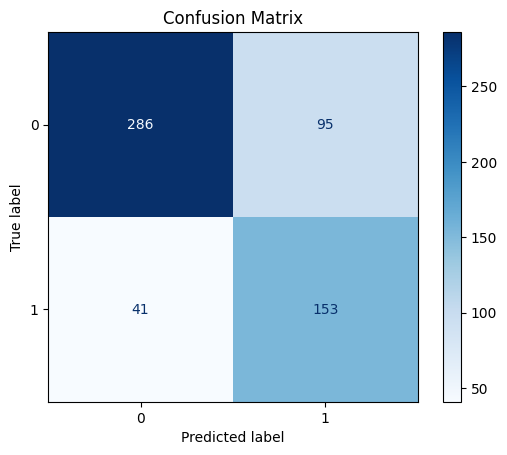

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       381
           1       0.62      0.79      0.69       194

    accuracy                           0.76       575
   macro avg       0.75      0.77      0.75       575
weighted avg       0.79      0.76      0.77       575

Acurracy score:0.7634782608695653, 
Precision score:0.6169354838709677, 
f1 score: 0.6923076923076923, 
recall: 0.788659793814433


In [101]:
#result on train data
results_plot(Y_clean_train, pred_clean_train, best_logi_model1)

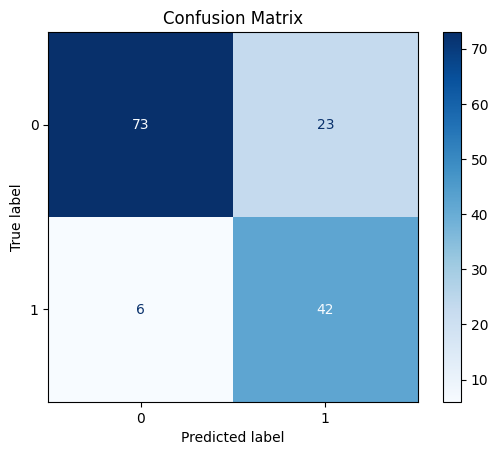

              precision    recall  f1-score   support

           0       0.92      0.76      0.83        96
           1       0.65      0.88      0.74        48

    accuracy                           0.80       144
   macro avg       0.79      0.82      0.79       144
weighted avg       0.83      0.80      0.80       144

Acurracy score:0.7986111111111112, 
Precision score:0.6461538461538462, 
f1 score: 0.7433628318584071, 
recall: 0.875


In [103]:
results_plot(Y_clean_test, best_logi_model1.predict(X_test_p), best_logi_model1)

In [106]:
df_1 = df.copy()

##### Roc and Auc for logistic model

In [ ]:
def roc_auc_plot(model, x_test, true_output, model_algo):
    """
    parameters:
    model:the model you have choose to use
    test_data: your input x
    y_data: the output/prediction
    model_algo: the type of algorithm
    """
    y_probs = model.predict_proba(x_test)[:, 1]

    # Compute FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(true_output, y_probs)
    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'ROC Curve for {model_algo}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

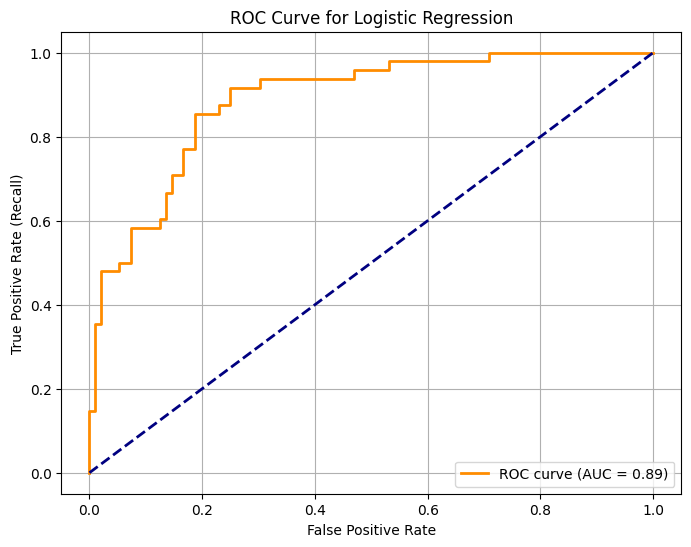

In [144]:
roc_auc_plot(best_logi_model1,X_test_p, Y_clean_test, "Logistic Regression")

##### Checking predict probability and performing hist plot on all the features

In [111]:
predict_proba = best_logi_model1.predict_proba(X_train_p)[:, 1]

<Axes: xlabel='Glucose', ylabel='Count'>

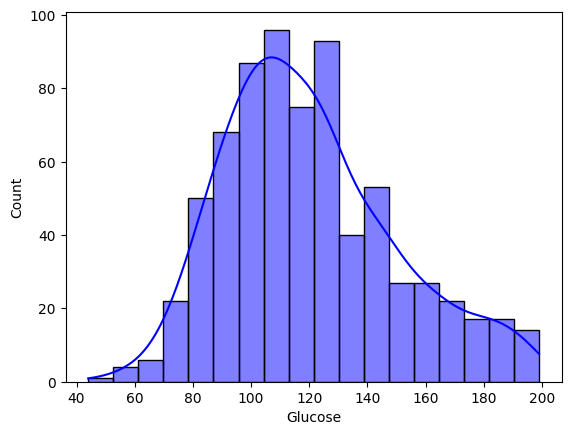

In [112]:
sns.histplot(df[~outliers]['Glucose'], kde=True, color='blue')

<Axes: xlabel='Glucose', ylabel='Count'>

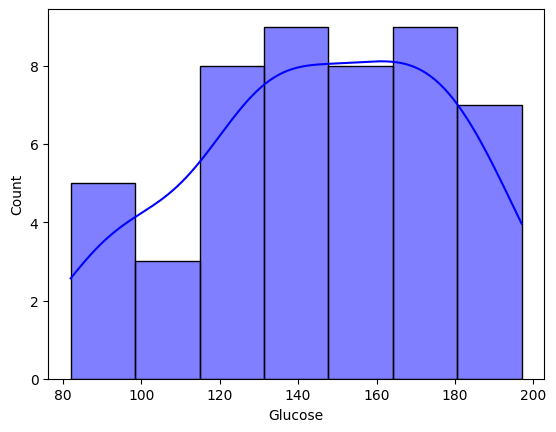

In [113]:
sns.histplot(df[outliers]['Glucose'], kde=True, color='blue')

<Axes: xlabel='Glucose', ylabel='Count'>

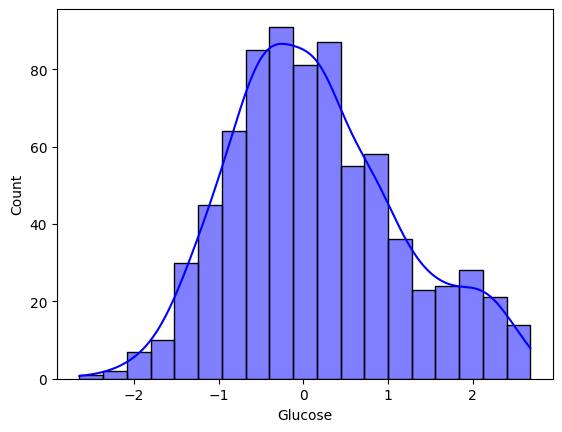

In [114]:
sns.histplot(X_res['Glucose'], kde=True, color='blue')

<Axes: xlabel='Glucose', ylabel='Count'>

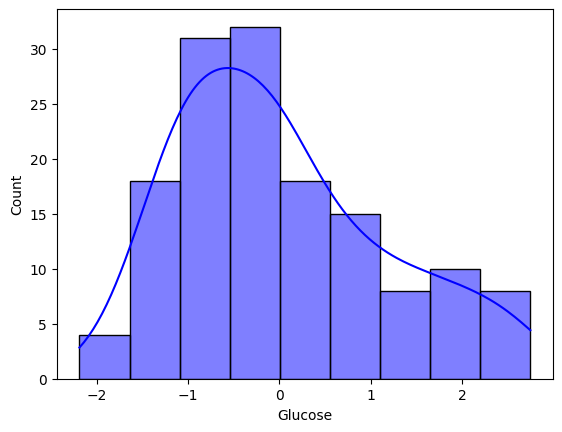

In [115]:
sns.histplot(X_clean_test['Glucose'], kde=True, color='blue')

<Axes: xlabel='Glucose', ylabel='Count'>

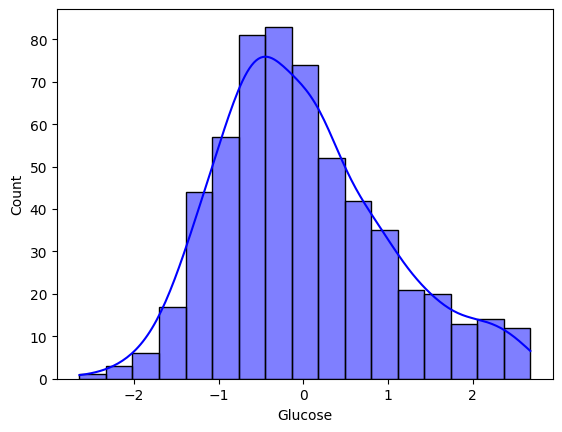

In [116]:
sns.histplot(X_clean_train['Glucose'], kde=True, color='blue')

In [121]:
#You can choose to use another threshold to increase your recall and trade off precision

In [117]:
predict_proba

array([0.13611368, 0.92628236, 0.89321869, 0.14264796, 0.95681301,
       0.55573839, 0.0494895 , 0.28519424, 0.18598425, 0.87995609,
       0.10213503, 0.51766738, 0.87029198, 0.04946064, 0.34280241,
       0.76170563, 0.15529044, 0.13188884, 0.06054645, 0.86986384,
       0.71922854, 0.06069555, 0.55575851, 0.54799475, 0.32797413,
       0.86597643, 0.04914329, 0.87227303, 0.43331285, 0.89420118,
       0.53082002, 0.89264   , 0.48306806, 0.42354707, 0.63919762,
       0.71774786, 0.06517256, 0.68599493, 0.62832847, 0.13508416,
       0.05273914, 0.01538595, 0.86370612, 0.29999621, 0.9324527 ,
       0.4386204 , 0.69372566, 0.17280859, 0.23042439, 0.91348411,
       0.70943749, 0.91057401, 0.43035405, 0.89557387, 0.62733893,
       0.51239583, 0.42311223, 0.0805285 , 0.77464786, 0.02238789,
       0.52413135, 0.02283153, 0.39245235, 0.09966654, 0.44720905,
       0.10007372, 0.12701351, 0.57974019, 0.72085107, 0.1357488 ,
       0.94124847, 0.60726849, 0.21455971, 0.33663934, 0.93314

In [119]:
pred_04 = (predict_proba>=0.4).astype(int)
pred_04.shape

(575,)

In [120]:
results(Y_clean_train, pred_04)

Acurracy score:0.7443478260869565, 
Precision score:0.5818815331010453, 
f1 score: 0.6943866943866944, 
recall: 0.8608247422680413


##### Decision Tree and classification model

##### Base model

In [124]:
random_try = RandomForestClassifier()

In [125]:
random_try.fit(X_res_p, Y_res)

RandomForestClassifier()

In [126]:
results(Y_clean_train, random_try.predict(X_train_p))

Acurracy score:1.0, 
Precision score:1.0, 
f1 score: 1.0, 
recall: 1.0


In [127]:
results(Y_clean_test, random_try.predict(X_test_p))

Acurracy score:0.75, 
Precision score:0.603448275862069, 
f1 score: 0.660377358490566, 
recall: 0.7291666666666666


##### Tweaking hyperparameters and finding the best model

In [128]:
#random forest classification
rf = RandomForestClassifier(
    #n_estimators=100,    # number of trees
    #max_depth=4,         # keep each tree small
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [129]:
param_random = {
    'n_estimators':[100, 128, 200],
    'max_depth':[3,4,5],
    'min_samples_split':[15,20,25],
    'min_samples_leaf': [6, 7, 10],
    'max_features':['sqrt', 0.5]
}

In [131]:
grid_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_random,
    cv=skf,
    scoring= make_scorer(f1_score),
    verbose=1
)

In [132]:
grid_random.fit(X_res_p, Y_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   param_distributions={'max_depth': [3, 4, 5],
                                        'max_features': ['sqrt', 0.5],
                                        'min_samples_leaf': [6, 7, 10],
                                        'min_samples_split': [15, 20, 25],
                                        'n_estimators': [100, 128, 200]},
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=1)

In [133]:
print(f"Best param : {grid_random.best_params_}")
print(f"Best score : {grid_random.best_score_}")
print(f"Best estimator : {grid_random.best_estimator_}")

Best param : {'n_estimators': 128, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 0.5, 'max_depth': 4}
Best score : 0.7992319405883507
Best estimator : RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=0.5,
                       min_samples_leaf=6, min_samples_split=20,
                       n_estimators=128, n_jobs=-1, random_state=42)


In [134]:
best_rf_model = grid_random.best_estimator_

In [135]:
best_rf_model1 = best_rf_model.fit(X_res_p, Y_res)

In [166]:
best_rf_model1.feature_importances_

array([0.0302995 , 0.35327017, 0.01498892, 0.02878572, 0.08919714,
       0.15430691, 0.04543488, 0.1608284 , 0.02694623, 0.0139929 ,
       0.01136331, 0.04140579, 0.02918012])

<Axes: title={'center': 'Feature Importance in RandomForest'}>

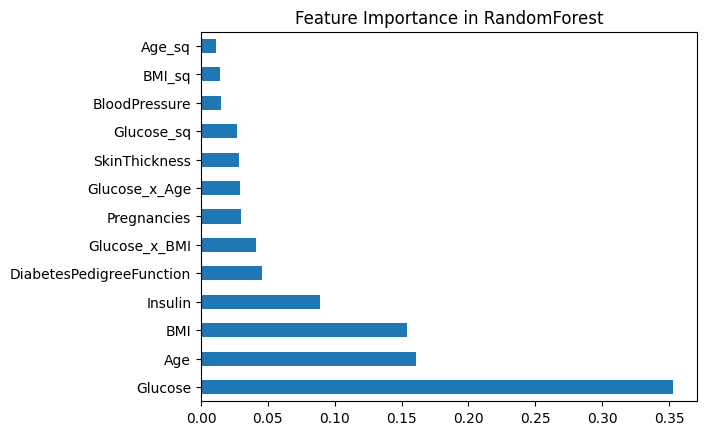

In [169]:
feat_imp = pd.Series(best_rf_model1.feature_importances_, index=X_train_p.columns).sort_values(ascending=False)
plt.title("Feature Importance in RandomForest")
feat_imp.plot.barh()

In [136]:
pred_rf = best_rf_model1.predict(X_train_p)

In [137]:
results(Y_clean_train, pred_rf)

Acurracy score:0.7965217391304348, 
Precision score:0.6521739130434783, 
f1 score: 0.738255033557047, 
recall: 0.8505154639175257


In [138]:
results(Y_clean_test, best_rf_model1.predict(X_test_p))

Acurracy score:0.7569444444444444, 
Precision score:0.6, 
f1 score: 0.6902654867256637, 
recall: 0.8125


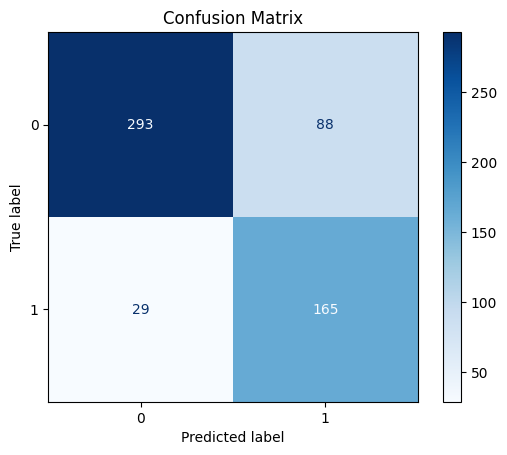

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       381
           1       0.65      0.85      0.74       194

    accuracy                           0.80       575
   macro avg       0.78      0.81      0.79       575
weighted avg       0.82      0.80      0.80       575

Acurracy score:0.7965217391304348, 
Precision score:0.6521739130434783, 
f1 score: 0.738255033557047, 
recall: 0.8505154639175257


In [139]:
results_plot(Y_clean_train, pred_rf, best_rf_model1)

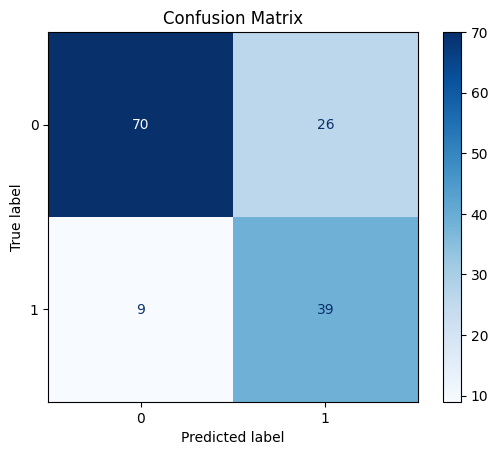

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        96
           1       0.60      0.81      0.69        48

    accuracy                           0.76       144
   macro avg       0.74      0.77      0.75       144
weighted avg       0.79      0.76      0.76       144

Acurracy score:0.7569444444444444, 
Precision score:0.6, 
f1 score: 0.6902654867256637, 
recall: 0.8125


In [141]:
results_plot(Y_clean_test, best_rf_model1.predict(X_test_p), best_rf_model1)

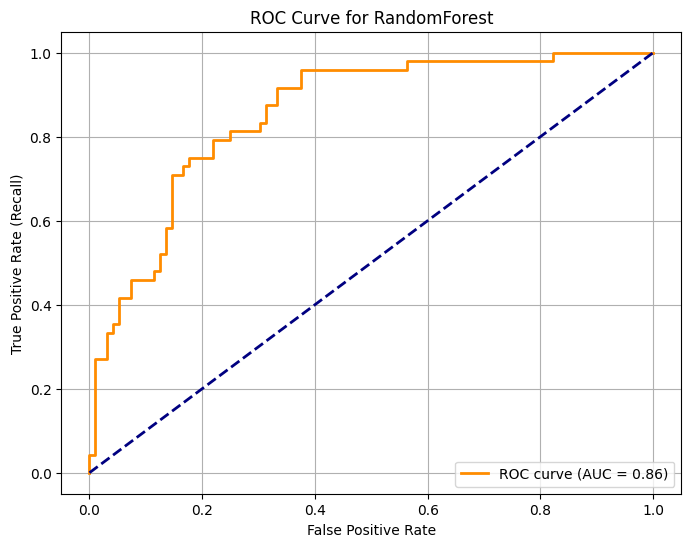

In [145]:
roc_auc_plot(best_rf_model1, X_test_p, Y_clean_test, "RandomForest")

##### Xgb boost

In [146]:
##### Baseline for xgboost

In [147]:
xgb1 = xgb.XGBClassifier()

In [148]:
xgb1.fit(X_res_p, Y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [149]:
results(Y_clean_train, xgb1.predict(X_train_p))

Acurracy score:1.0, 
Precision score:1.0, 
f1 score: 1.0, 
recall: 1.0


In [150]:
results(Y_clean_test, xgb1.predict(X_test_p))

Acurracy score:0.7361111111111112, 
Precision score:0.5892857142857143, 
f1 score: 0.6346153846153846, 
recall: 0.6875


In [224]:
###Hyper parameter tunning for xgboost

In [151]:
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_res_p, Y_res,
    test_size=0.2,
    stratify=Y_res,
    random_state=42
)

In [152]:
xgb_tune = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [153]:
param_grid_xgb = {
    'learning_rate':    [0.01, 0.03],      ## η: shrinkage of each tree’s contribution
    'n_estimators':     [50, 150, 120],             # number of boosting rounds
    'max_depth':        [4,5,6],               # tree depth
    'min_child_weight': [3,4,5],                  # leaf minimum Hessian weight
    'subsample':        [0.6, 0.8],                  # row sampling rate, this chooses rows to use some percent
    'colsample_bytree': [0.7, 0.8],             # feature sampling rate per tree, choose feature to select
    'reg_alpha':        [0.5,1],
    'reg_lambda':       [1.5], #1
    'scale_pos_weight': [1.2]
}

In [154]:
search = RandomizedSearchCV(
    xgb_tune,
    param_distributions=param_grid_xgb,
    n_iter=30,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

In [155]:
search.fit(
    X_subtrain, y_subtrain,
    eval_set=[(X_val, y_val)],
    verbose=False
)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8],
                                        'learning_rate': [0.01, 0.03],
                                        'max_depth': [4, 5, 6],
                                        'min_child_weight': [3, 4, 5],
                                        'n_estimators': [50, 150, 120],
                                        'reg_alpha': [0.5, 1],
                                        'reg_lambda': [1.5],
                                        'scale_pos_weight': [1.2],
                                        'subsample': [0.6, 0.8]},
                   random_state=42, scoring='f1')

In [156]:
best_params = search.best_params_

In [157]:
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.2,
 'reg_lambda': 1.5,
 'reg_alpha': 1,
 'n_estimators': 150,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.03,
 'colsample_bytree': 0.8}

In [158]:
final_model = xgb.XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [159]:
final_model.fit(
    X_subtrain, y_subtrain,
    eval_set=[(X_val, y_val)],
    #early_stopping_rounds=10,
    verbose=True
)

[0]	validation_0-logloss:0.69157
[1]	validation_0-logloss:0.68311
[2]	validation_0-logloss:0.67610
[3]	validation_0-logloss:0.66908
[4]	validation_0-logloss:0.66296
[5]	validation_0-logloss:0.65609
[6]	validation_0-logloss:0.64921
[7]	validation_0-logloss:0.64292
[8]	validation_0-logloss:0.63794
[9]	validation_0-logloss:0.63219
[10]	validation_0-logloss:0.62734
[11]	validation_0-logloss:0.62228
[12]	validation_0-logloss:0.61658
[13]	validation_0-logloss:0.61169
[14]	validation_0-logloss:0.60787
[15]	validation_0-logloss:0.60299
[16]	validation_0-logloss:0.59859
[17]	validation_0-logloss:0.59430
[18]	validation_0-logloss:0.59020
[19]	validation_0-logloss:0.58632
[20]	validation_0-logloss:0.58297
[21]	validation_0-logloss:0.57856
[22]	validation_0-logloss:0.57524
[23]	validation_0-logloss:0.57210
[24]	validation_0-logloss:0.56854
[25]	validation_0-logloss:0.56566
[26]	validation_0-logloss:0.56293
[27]	validation_0-logloss:0.56016
[28]	validation_0-logloss:0.55765
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

<Axes: title={'center': 'Feature Importance in XGboost'}>

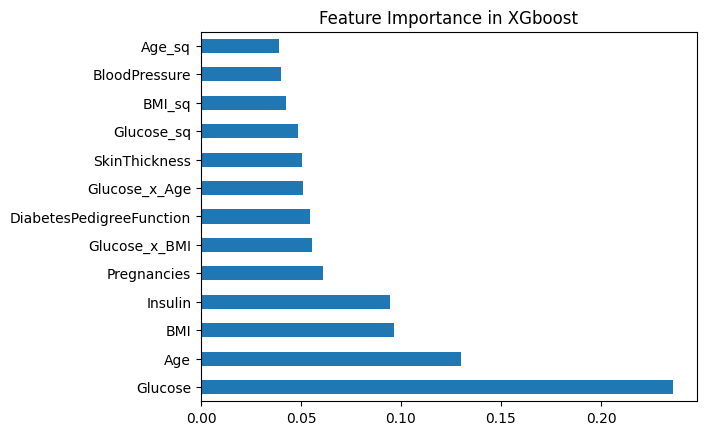

In [171]:
feat_imp_xg = pd.Series(final_model.feature_importances_, index=X_train_p.columns).sort_values(ascending=False)
plt.title("Feature Importance in XGboost")
feat_imp_xg.plot.barh()

In [160]:
results(Y_clean_train, final_model.predict(X_train_p))

Acurracy score:0.8330434782608696, 
Precision score:0.7024793388429752, 
f1 score: 0.7798165137614679, 
recall: 0.8762886597938144


In [161]:
results(Y_clean_test, final_model.predict(X_test_p))

Acurracy score:0.7708333333333334, 
Precision score:0.6119402985074627, 
f1 score: 0.7130434782608696, 
recall: 0.8541666666666666


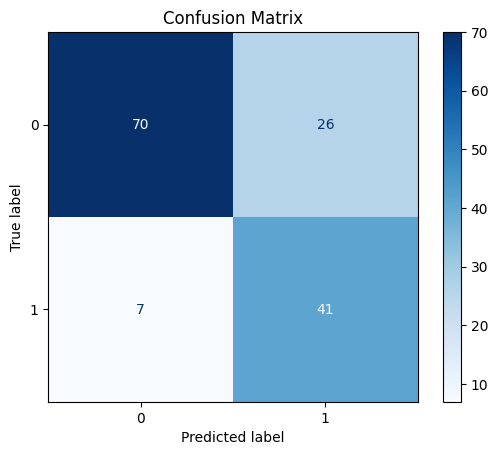

              precision    recall  f1-score   support

           0       0.91      0.73      0.81        96
           1       0.61      0.85      0.71        48

    accuracy                           0.77       144
   macro avg       0.76      0.79      0.76       144
weighted avg       0.81      0.77      0.78       144

Acurracy score:0.7708333333333334, 
Precision score:0.6119402985074627, 
f1 score: 0.7130434782608696, 
recall: 0.8541666666666666


In [162]:
results_plot(Y_clean_test, final_model.predict(X_test_p), final_model)

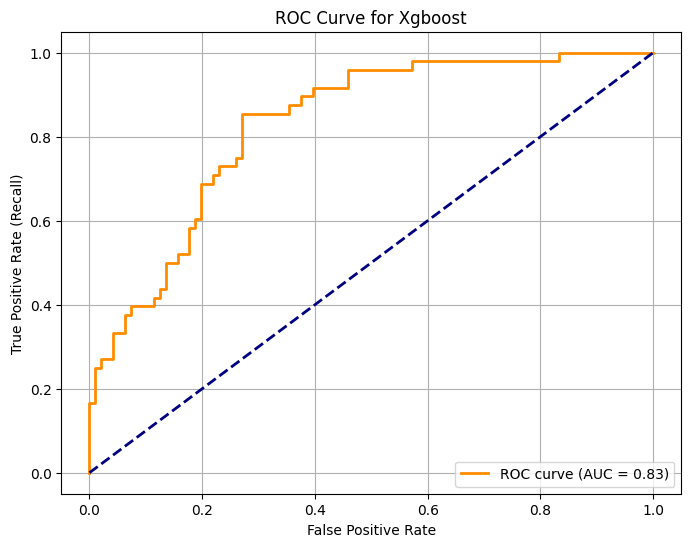

In [164]:
roc_auc_plot(final_model, X_test_p, Y_clean_test, "Xgboost")

In [172]:
print(pd.__version__)

2.2.1
